<a href="https://colab.research.google.com/github/GIRIME262/transferencia-de-estilo-neuronal/blob/main/Trabajo_Final_CNN_Pablo_Germ%C3%A1n_Giri_Style_Transfer_N%C2%B01%2C_2%2C_3%2C_4%2C_5%2C_6_y_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [ ]:
# Imagen para estilo

!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output-pesos-original

--2021-01-10 01:39:28--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.007s  

2021-01-10 01:39:28 (32.7 MB/s) - ‘La_noche_estrellada1.jpg’ saved [223725/223725]

--2021-01-10 01:39:28--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) [ima

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

Using TensorFlow backend.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


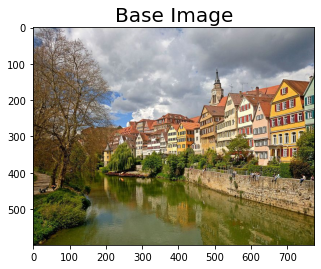

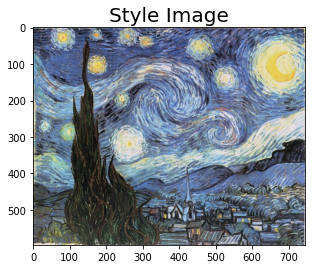

In [ ]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img('/content/775px-Neckarfront_Tübingen_Mai_2017.jpg')
plt.imshow(img1)
plt.figure()
plt.title("Style Image",fontsize=20)
img2 = load_img('/content/La_noche_estrellada1.jpg')
plt.imshow(img2)

In [ ]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")
result_prefix = Path("/content/output-pesos-original")

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta: El principio de la transferencia de estilo neuronal es definir dos funciones de distancia, una que describe cuán diferente es el contenido de dos imágenes, (content_weight), y otra que describe la diferencia entre las dos imágenes en términos de su estilo, (style_weight).



In [ ]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1



In [ ]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta: 

El preprocesamiento de las imágenes consiste en dar a las imágenes el formato que requiere nuestra red. En el caso de Keras, al tratarse del modelo VGG19, el propio modelo cuenta con una función de preprocesamiento de imágene: preprocess_input.
 
1.   img = np.expand_dims(img, axis=0): agrupamos todas las imágenes en un único array, ya que, como hemos dicho, Keras trabaja con batches de imágenes. Así, el resultado de este paso será un array con dimensiones (3, ancho, alto, 3).  
2.   img = vgg19.preprocess_input(img):  sustrae la media de los valores RGB del dataset Imagenet (con el cual está entrenado VGG19), de tal forma que consigamos que las imágenes tengan promedio cero. Esto es un preprocesamiento típico en las imágenes, ya que esto evita que los gradiente sean muy «extremos», consiguiendo por tanto mejores resultados del modelo (enlace).



In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

El preprocesamiento de las imágenes, acabamos de ver como convertir imágenes en ARRAYS en un tipo de datos que interprete nuestro modelo TENSORES.  
En la siguiente celda, se realiza lo contrario, se convierte el resultado del modelo TENSOR, en una imagen que se pueda visualizar.



In [ ]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [ ]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [ ]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')
model.summary()

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])


80142336/80134624 [==============================] - 1s 0us/step
Model loaded.
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_______________________________________________

# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?

La matriz de Gram la encargada de calcular las correlaciones de características. Se utiliza para representar la correlación entre cada filtro en una representación intermedia. La matriz de Gram se calcula tomando el producto escalar de la representación intermedia desenrollada y su transposición. 
La función de costo de estilo para una capa se calcula utilizando la matriz Gram de las activaciones de esa capa. La función de costo de estilo general se obtiene utilizando varias capas ocultas.



- ¿Por qué se permutan las dimensiones de x?

La dimensión permuta por que tiene que pasar, de una convolucional a un vector de característica dimensionales. 

In [ ]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram



# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:

1) La style_loss función, que mantiene la imagen generada cerca de las texturas locales de la imagen de referencia de estilo. Definir la función de pérdida para el estilo tiene más trabajo que contenido, ya que en la informática participan múltiples capas. La información de estilo se mide como la cantidad de correlación presente entre los mapas de características por capa.


In [ ]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

2) La content_loss función, que mantiene la representación de alto nivel de la imagen generada cerca de la imagen base. Se asegura de que el contenido que queremos en la imagen generada se capture de manera eficiente. Se ha observado que CNN captura información sobre el contenido en los niveles más altos de la red, mientras que los niveles más bajos están más enfocados en los valores de píxeles individuales.


In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


3) La total_variation_loss función, una pérdida de regularización que mantiene la imagen generada localmente coherente.

In [ ]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [ ]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [ ]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?


1) La función fmin_l_bfgs_b es un optimizador de memoria limitada de la librería scipy, l-bfgs determina en qué dirección ir y la distancia haciendo una búsqueda lineal.  

2) El paper implementa Stochastic Gradient Descent. 

3) l-bfgs aprende más rápido que SGD en la transferencia de estilo. No hay nada estocástico aquí (no estamos creando mini lotes aleatorios con diferentes conjuntos de datos), en cambio, el optimizador sigue obteniendo la misma imagen única.


In [ ]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [ ]:
evaluator = Evaluator()
iterations =1000
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)
best_loss, best_img = float('inf'), None###

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    if min_val < best_loss:
      best_loss = min_val
      best_img = x.copy()

    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))


Start of iteration 0
Current loss value: 13259870000.0
Image saved as /content/output-pesos-original/output_at_iteration_0.png
Iteration 0 completed in 6s
Start of iteration 1
Current loss value: 6357325000.0
Image saved as /content/output-pesos-original/output_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 4279058700.0
Image saved as /content/output-pesos-original/output_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 3266396000.0
Image saved as /content/output-pesos-original/output_at_iteration_3.png
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 2663937500.0
Image saved as /content/output-pesos-original/output_at_iteration_4.png
Iteration 4 completed in 6s
Start of iteration 5
Current loss value: 2298523600.0
Image saved as /content/output-pesos-original/output_at_iteration_5.png
Iteration 5 completed in 6s
Start of iteration 6
Current loss value: 2058065700.0
Image saved as /conte

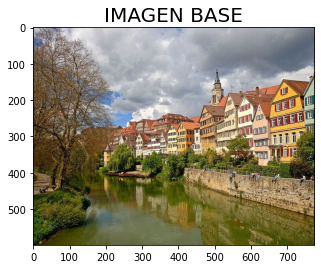

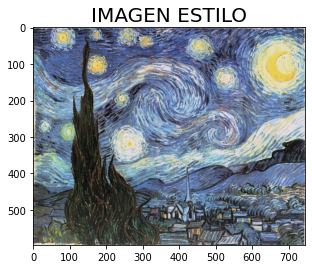

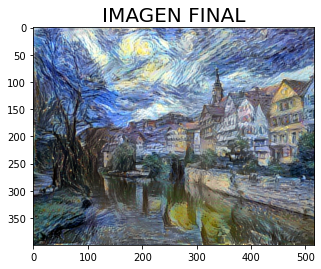

In [ ]:
plt.figure()
plt.title("IMAGEN BASE",fontsize=20)
img1 = load_img('/content/775px-Neckarfront_Tübingen_Mai_2017.jpg')
plt.imshow(img1)

plt.figure()
plt.title("IMAGEN ESTILO",fontsize=20)
img2 = load_img('/content/La_noche_estrellada1.jpg')
plt.imshow(img2)

plt.figure()
plt.title("IMAGEN FINAL",fontsize=20)
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)